## 50

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2021-06-08 16:58:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  11.6MB/s    in 2.4s    

2021-06-08 16:58:28 (11.6 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

train.to_csv('train.txt', sep='\t', index=False)
valid.to_csv('valid.txt', sep='\t', index=False)
test.to_csv('test.txt', sep='\t', index=False)

In [ ]:
train['CATEGORY'].value_counts(),valid['CATEGORY'].value_counts(),test['CATEGORY'].value_counts()

(b    4501
 e    4235
 t    1220
 m     728
 Name: CATEGORY, dtype: int64, b    563
 e    529
 t    153
 m     91
 Name: CATEGORY, dtype: int64, b    563
 e    530
 t    152
 m     91
 Name: CATEGORY, dtype: int64)

## 51

In [ ]:
import string
import re

def preprocessing(text):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = re.sub('[0-9]+', '0', text.translate(table).lower()) 
    return text
df = pd.concat([train, valid, test], axis=0)
df.reset_index(drop=True, inplace=True) 
df['TITLE'] = df['TITLE'].map(lambda x: preprocessing(x))
print(df.head())


                                               TITLE CATEGORY
0  refile update 0 european car sales up for sixt...        b
1  amazon plans to fight ftc over mobile app purc...        t
2  kids still get codeine in emergency rooms desp...        m
3  what on earth happened between solange and jay...        e
4  nato missile defense is flight tested over hawaii        b


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

train_valid = df[:len(train) + len(valid)]
test = df[len(train) + len(valid):]
vec_tfidf = TfidfVectorizer(min_df=10, ngram_range=(1, 2)) 
X_train_valid = vec_tfidf.fit_transform(train_valid['TITLE']) 
X_test = vec_tfidf.transform(test['TITLE'])
X_train_valid = pd.DataFrame(X_train_valid.toarray(), columns=vec_tfidf.get_feature_names())
X_test = pd.DataFrame(X_test.toarray(), columns=vec_tfidf.get_feature_names())
X_train = X_train_valid[:len(train)]
X_valid = X_train_valid[len(train):]
X_train.to_csv('X_train.txt', sep='\t', index=False)
X_valid.to_csv('X_valid.txt', sep='\t', index=False)
X_test.to_csv('X_test.txt', sep='\t', index=False)

print(X_train.head())

    0m  0million  0nd   0s  0st  ...  yuan  zac  zac efron  zendaya  zone
0  0.0       0.0  0.0  0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
1  0.0       0.0  0.0  0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
2  0.0       0.0  0.0  0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
3  0.0       0.0  0.0  0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0
4  0.0       0.0  0.0  0.0  0.0  ...   0.0  0.0        0.0      0.0   0.0

[5 rows x 2815 columns]


## 52

ロジスティック回帰
https://istat.co.jp/ta_commentary/logistic

In [ ]:
from sklearn.linear_model import LogisticRegression

# model
lg = LogisticRegression(random_state=123, max_iter=10000)
lg.fit(X_train, train['CATEGORY'])
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 53

In [ ]:
import numpy as np
def score(lg, X):
    return [np.max(lg.predict_proba(X), axis=1), lg.predict(X)]
train_pred = score(lg, X_train)
test_pred = score(lg, X_test)
print(train_pred)

[array([0.84029321, 0.67900957, 0.55639016, ..., 0.86051156, 0.61358963,
       0.90827882]), array(['b', 't', 'm', ..., 'b', 'm', 'e'], dtype=object)]


## 54

In [ ]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])
print(f'train acc：{train_accuracy:.3f}')
print(f'test acc：{test_accuracy:.3f}')

train acc：0.927
test acc：0.885


## 55

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
train_cm = confusion_matrix(train['CATEGORY'], train_pred[1])
print("train confusion matrix")
print(train_cm)
test_cm = confusion_matrix(test['CATEGORY'], test_pred[1])
print("test confusion matrix")
print(test_cm)


train confusion matrix
[[4344   93    8   56]
 [  52 4173    2    8]
 [  96  125  494   13]
 [ 192  133    7  888]]
test confusion matrix
[[528  20   2  13]
 [ 12 516   1   1]
 [ 11  26  52   2]
 [ 38  26   1  87]]


## 56

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_scores(y_true, y_pred):
    # Precision
    precision = precision_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm']) 
    precision = np.append(precision, precision_score(y_true, y_pred, average='micro'))  
    precision = np.append(precision, precision_score(y_true, y_pred, average='macro'))  
    # recall
    recall = recall_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
    recall = np.append(recall, recall_score(y_true, y_pred, average='micro'))
    recall = np.append(recall, recall_score(y_true, y_pred, average='macro'))
    # F1 score
    f1 = f1_score(test['CATEGORY'], test_pred[1], average=None, labels=['b', 'e', 't', 'm'])
    f1 = np.append(f1, f1_score(y_true, y_pred, average='micro'))
    f1 = np.append(f1, f1_score(y_true, y_pred, average='macro'))
    scores = pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])
    return scores
print(calculate_scores(test['CATEGORY'], test_pred[1]))

             適合率       再現率     F1スコア
b       0.896435  0.937833  0.916667
e       0.877551  0.973585  0.923077
t       0.844660  0.572368  0.682353
m       0.928571  0.571429  0.707483
マイクロ平均  0.885479  0.885479  0.885479
マクロ平均   0.886804  0.763804  0.807395


## 57

In [ ]:
features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):
    print("categoty")
    best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
    worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
    display(pd.concat([best10, worst10], axis=0))
    print("")

categoty


,1,2,3,4,5,6,7,8,9,10
重要度上位,bank,fed,china,ecb,stocks,euro,obamacare,oil,yellen,dollar
重要度下位,video,ebola,the,her,and,she,apple,google,star,microsoft



categoty


,1,2,3,4,5,6,7,8,9,10
重要度上位,kardashian,chris,her,movie,star,film,paul,he,wedding,she
重要度下位,us,update,google,study,china,gm,ceo,facebook,apple,says



categoty


,1,2,3,4,5,6,7,8,9,10
重要度上位,ebola,study,cancer,drug,mers,fda,cases,cdc,could,cigarettes
重要度下位,facebook,gm,ceo,apple,bank,deal,google,sales,climate,twitter



categoty


,1,2,3,4,5,6,7,8,9,10
重要度上位,google,facebook,apple,microsoft,climate,gm,nasa,tesla,comcast,heartbleed
重要度下位,stocks,fed,her,percent,drug,american,cancer,ukraine,still,shares


## 58

In [ ]:
result = []
for C in np.logspace(-5, 4, 10, base=10):
    lg = LogisticRegression(random_state=123, max_iter=10000, C=C)
    lg.fit(X_train, train['CATEGORY'])
    train_pred = score(lg, X_train)
    valid_pred = score(lg, X_valid)
    test_pred = score(lg, X_test)
    train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1])
    valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])
    test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1])
    result.append([C, train_accuracy, valid_accuracy, test_accuracy])

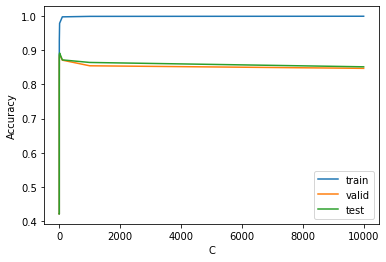

In [ ]:
result = np.array(result).T
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.legend()
plt.show()

## 59

C,l1_ratioを探索

In [ ]:
!pip install optuna
import optuna

def objective_lg(trial):
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
    C = trial.suggest_loguniform('C', 1e-4, 1e4)    
    lg = LogisticRegression(random_state=123, 
                            max_iter=10000, 
                            penalty='elasticnet', 
                            solver='saga', 
                            l1_ratio=l1_ratio, 
                            C=C)
    lg.fit(X_train, train['CATEGORY'])  
    valid_pred = score(lg, X_valid)  
    valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1])       
    return valid_accuracy 
study = optuna.create_study(direction='maximize')
study.optimize(objective_lg, timeout=3600)

print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

l1_ratio = trial.params['l1_ratio']
C = trial.params['C']

lg = LogisticRegression(random_state=123, 
                        max_iter=10000, 
                        penalty='elasticnet', 
                        solver='saga', 
                        l1_ratio=l1_ratio, 
                        C=C)
lg.fit(X_train, train['CATEGORY'])

train_pred = score_lg(lg, X_train)
valid_pred = score_lg(lg, X_valid)
test_pred = score_lg(lg, X_test)

train_accuracy = accuracy_score(train['CATEGORY'], train_pred[1]) 
valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred[1]) 
test_accuracy = accuracy_score(test['CATEGORY'], test_pred[1]) 

print(f'acc train：{train_accuracy:.3f}')
print(f'acc valid：{valid_accuracy:.3f}')
print(f'acc test：{test_accuracy:.3f}')

[I 2021-06-08 17:35:57,190] A new study created in memory with name: no-name-15cefd82-a1ba-4b13-ab6f-b2b397b9b790
[I 2021-06-08 17:35:58,196] Trial 0 finished with value: 0.4214071856287425 and parameters: {'l1_ratio': 0.27450334588699676, 'C': 0.000147668641533175}. Best is trial 0 with value: 0.4214071856287425.
[I 2021-06-08 17:41:30,337] Trial 1 finished with value: 0.875 and parameters: {'l1_ratio': 0.6849942368167306, 'C': 25.41972747816227}. Best is trial 1 with value: 0.875.
[I 2021-06-08 18:15:39,640] Trial 2 finished with value: 0.8547904191616766 and parameters: {'l1_ratio': 0.6331398589931918, 'C': 5272.220719362687}. Best is trial 1 with value: 0.875.
[I 2021-06-08 18:15:59,402] Trial 3 finished with value: 0.4214071856287425 and parameters: {'l1_ratio': 0.0506024276047885, 'C': 0.001108125346911354}. Best is trial 1 with value: 0.875.
[I 2021-06-08 18:20:57,466] Trial 4 finished with value: 0.8712574850299402 and parameters: {'l1_ratio': 0.23072534399463462, 'C': 68.11483